# High Energy Code

In this notebook, we demonstrate how the high energy code works and run some cross checks. 

## Initialization

In [5]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

from astropy.io import fits

import numpy as np
import pickle
import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
import darkhistory.history.tla as tla

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

np.set_printoptions(threshold=np.nan)

## Inputs

The inputs of the code are as follows: 

1. A `Spectrum` or `Spectra` object containing the injected electron spectrum, or the injected electron spectrum as a function of redshift, and/or 

2. A `Spectrum` or `Spectra` object containing the injected photon spectrum, or the injected photon spectrum as a function of redshift.

There are 3 modes of use. For a `Spectrum` input, the spectrum can be interpreted either as a single injection at a particular redshift, and no subsequent injections, or as a spectrum with the redshift dependence factored out, with a continuous injection at every step. For a `Spectra` input, the spectrum at each redshift step is injected. 

We will start with the single injection case here. As an example, we begin with a $\delta$-function injection of two 1 MeV electrons at some arbitrary energy, start at redshift $1+z = 2000$. Let's first initialize the spectrum. 

In [11]:
eleceng = np.logspace(1, 13, 100)
photeng = np.logspace(-4, 13, 100)
rs = 5

elec_spec_init = spectools.rebin_N_arr(np.array([1]), 
                                      np.array([1e12]),
                                      eleceng)

elec_spec_init.rs = rs

## Resolved Injected Electrons

High energy electrons ($\gg$ keV) primarily cool by inverse compton scattering (ICS), at a rate that is much faster than the smallest timestep allowable in this code ($\Delta \log (1+z) = 10^{-3}$). Lower energy electrons also cool quickly, but via atomic processes.

Low energy electrons ($< 3.5$ keV) are read out immediately and saved in a `Spectra` object. High energy electrons will be converted into a photon spectrum through ICS, and an estimate for the energy loss due to atomic cooling also produced. 

For now, we will assume only ICS for high energy electrons. 

In [26]:
user="hongwan"
raw_nonrel_ICS_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

(ics_phot_tf, ics_lowengelec_tf) = get_ics_cooling_tf(raw_nonrel_ICS_tf,
                                                     raw_rel_ICS_tf,
                                                     raw_engloss_tf,
                                                     eleceng, photeng, rs)

Check that the result makes sense, relative to some reference data.

In [32]:
mwimp = 1e12
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng_ref = np.sqrt(englow*enghigh)

nphoteng = 500
dlnphoteng = np.log(mwimp/1e-2)/nphoteng
photenglow = 1e-2*np.exp(np.arange(nphoteng)*dlnphoteng)
photenghigh = 1e-2*np.exp((np.arange(nphoteng)+1)*dlnphoteng)
photeng_ref = np.sqrt(photenglow*photenghigh)

ICS_test_filename = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_test.fits"
ICS_test = fits.open(ICS_test_filename)
ICS_test_spec = ICS_test[0].data
ICS_test_spec = np.transpose(ICS_test_spec)
ICS_test_list_spec = [Spectrum(photeng_ref, arr, in_eng=in_eng) for (arr, in_eng) in zip(ICS_test_spec, eleceng_ref)]
ICS_test_tf = tf.TransFuncAtRedshift(ICS_test_list_spec, dlnz=-1)

../darkhistory/spec/transferfunction.py:567: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  np.issubdtype(type(ind),int)
../darkhistory/spec/transferfunction.py:568: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  or np.issubdtype(type(ind), float)


Text(0,0.5,'Number of Photons in Each Bin')

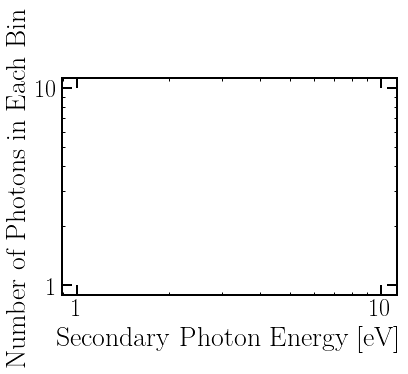

In [56]:
plt.figure()

ax = plt.gca()
ics_phot_tf.plot(ax, ind=[3.5e3, 5e5], indtype='in_eng')

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')

plt.ylabel('Number of Photons in Each Bin')